# Vehicle Image Generation Using GAN


In [2]:
"""
# Vehicle Image Generation using GAN
## Project Description
This project implements a Generative Adversarial Network (GAN) to generate vehicle images from a parking lot dataset.

## Dataset
- Source: UFPR04 Parking Lot Database
- Contents: Manually segmented vehicle images from parking lot security cameras
- Characteristics: Single vehicle per image, varying sizes due to camera perspective

## References
1. Vanilla GAN Implementation: https://github.com/SudharshanShanmugasundaram/VanillaGAN/blob/master/GAN.ipynb
2. Tim Salimans, et. al. "Improved Techniques for Training GANs"
3. Shane Barratt, et al. "A notes on the inception score"
"""

# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

## Dataset
- **Source**: The vehicle images are sourced from the UFPR04 Parking Lot Database, which can be found at [UFPR04 Parking Lot Database](http://web.inf.ufpr.br/vri/databases/parking-lot-database/).
- **Characteristics**:
  - Each image contains one vehicle.
  - Images may vary in size due to the distance from the camera.
  - The dataset filename is `Parking_Lot_Vehicle_Images_UFPR04.zip`.
- **Preprocessing**: Images will be rescaled to a uniform size (e.g., 64x64 pixels) to ensure consistency during training.


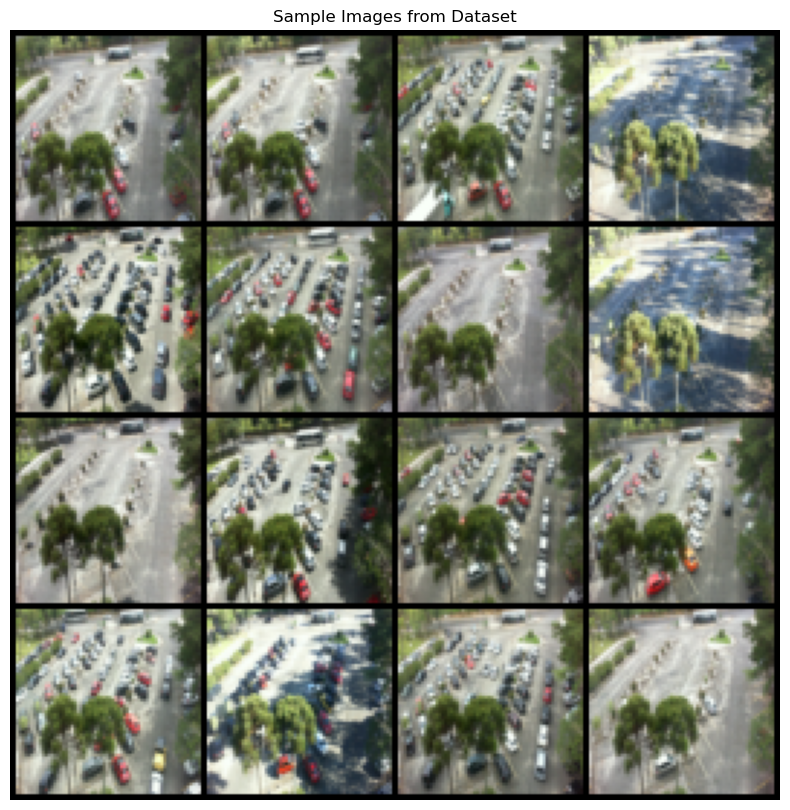

In [3]:
# Step: Load Vehicle Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Cell 2: Data Preparation
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Standardize image size
    transforms.CenterCrop(64),    # Ensure square images
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset
dataset_path = 'Parking_Lot_Vehicle_Images_UFPR04'
dataset = ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Display sample images from dataset
def show_dataset_samples():
    plt.figure(figsize=(10, 10))
    batch = next(iter(dataloader))[0]
    grid = make_grid(batch[:16], nrow=4, normalize=True)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis('off')
    plt.title('Sample Images from Dataset')
    plt.show()

show_dataset_samples()


### Explanation: Using ImageFolder to load the dataset in PyTorch format. The transform resizes the images to 64x64 and normalizes them.


## Implementation of Generative Adversarial Network
### Network Structure
The GAN consists of two main components:
1. **Generator**: This network generates fake images from random noise.
2. **Discriminator**: This network evaluates whether the images are real (from the dataset) or fake (generated by the generator).


In [4]:
# Step: Define Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: 3 x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.3),
            
            # State: 64 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.3),
            
            # State: 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.3),
            
            # State: 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # State: 512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1)

discriminator = Discriminator()
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.3, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout2d(p=0.3, inplace=False)
    (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout2d(p=0.3, inplace=False)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
  

# Discriminator Architecture Analysis

The Discriminator is a crucial component of the Generative Adversarial Network (GAN) that evaluates whether the input images are real (from the dataset) or fake (generated by the Generator). Below is a detailed analysis of the Discriminator's architecture.

## Architecture Overview

The Discriminator is implemented as a sequential model consisting of several convolutional layers, activation functions, normalization layers, and dropout layers. The architecture is designed to progressively downsample the input images while extracting relevant features.

### Layer Breakdown

1. **Input Layer**:
   - **Input Shape**: 3 x 64 x 64 (RGB image of size 64x64 pixels)

2. **Convolutional Layers**:
   - **Layer 1**: 
     - Type: `Conv2d`
     - Output Channels: 64
     - Kernel Size: (4, 4)
     - Stride: (2, 2)
     - Padding: (1, 1)
     - Activation: `LeakyReLU`
     - Dropout: `Dropout2d` (p=0.3)
   - **Layer 2**: 
     - Type: `Conv2d`
     - Output Channels: 128
     - Kernel Size: (4, 4)
     - Stride: (2, 2)
     - Padding: (1, 1)
     - Batch Normalization
     - Activation: `LeakyReLU`
     - Dropout: `Dropout2d` (p=0.3)
   - **Layer 3**: 
     - Type: `Conv2d`
     - Output Channels: 256
     - Kernel Size: (4, 4)
     - Stride: (2, 2)
     - Padding: (1, 1)
     - Batch Normalization
     - Activation: `LeakyReLU`
     - Dropout: `Dropout2d` (p=0.3)
   - **Layer 4**: 
     - Type: `Conv2d`
     - Output Channels: 512
     - Kernel Size: (4, 4)
     - Stride: (2, 2)
     - Padding: (1, 1)
     - Batch Normalization
     - Activation: `LeakyReLU`
   - **Output Layer**: 
     - Type: `Conv2d`
     - Output Channels: 1
     - Kernel Size: (4, 4)
     - Stride: (1, 1)
     - Activation: `Sigmoid`

### Summary of Layers

| Layer Type         | Output Channels | Kernel Size | Stride | Padding | Activation      |
|--------------------|-----------------|-------------|--------|---------|------------------|
| Conv2d             | 64              | (4, 4)      | (2, 2) | (1, 1)  | LeakyReLU        |
| Dropout2d          | -               | -           | -      | -       | -                |
| Conv2d             | 128             | (4, 4)      | (2, 2) | (1, 1)  | LeakyReLU        |
| BatchNorm2d        | 128             | -           | -      | -       | -                |
| Dropout2d          | -               | -           | -      | -       | -                |
| Conv2d             | 256             | (4, 4)      | (2, 2) | (1, 1)  | LeakyReLU        |
| BatchNorm2d        | 256             | -           | -      | -       | -                |
| Dropout2d          | -               | -           | -      | -       | -                |
| Conv2d             | 512             | (4, 4)      | (2, 2) | (1, 1)  | LeakyReLU        |
| BatchNorm2d        | 512             | -           | -      | -       | -                |
| Conv2d             | 1               | (4, 4)      | (1, 1) | -       | Sigmoid          |

### Key Features

- **LeakyReLU Activation**: This activation function allows a small gradient when the unit is not active, which helps prevent the "dying ReLU" problem and allows for better gradient flow during training.
- **Dropout Layers**: These layers help prevent overfitting by randomly setting a fraction of the input units to zero during training.
- **Batch Normalization**: This technique normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation, which helps stabilize and accelerate training.

### In The End

The Discriminator is designed to effectively learn to distinguish between real and generated images through a series of convolutional layers that progressively extract features while reducing spatial dimensions. The use of LeakyReLU, dropout, and batch normalization contributes to a robust training process, allowing the model to generalize better to unseen data.

This architecture is expected to perform well in identifying real vehicle images versus those generated by the GAN, although further tuning and experimentation may be necessary to optimize performance.

In [5]:
# Step: Define Generator Model
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            # State: 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # State: 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            # State: 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            # State: 64 x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: 3 x 64 x 64
        )
    
    def forward(self, x):
        return self.main(x)

generator = Generator()
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Generator Architecture Analysis

The Generator is a key component of the Generative Adversarial Network (GAN) that generates fake images from random noise. Below is a detailed analysis of the Generator's architecture.

## Architecture Overview

The Generator is implemented as a sequential model consisting of several transposed convolutional layers, activation functions, and normalization layers. The architecture is designed to progressively upsample the input noise vector into a full-sized image.

### Layer Breakdown

1. **Input Layer**:
   - **Input Shape**: 100 (latent dimension)

2. **Transposed Convolutional Layers**:
   - **Layer 1**: 
     - Type: `ConvTranspose2d`
     - Input Channels: 100
     - Output Channels: 512
     - Kernel Size: (4, 4)
     - Stride: (1, 1)
     - Activation: `BatchNorm2d`, `ReLU`
   - **Layer 2**: 
     - Type: `ConvTranspose2d`
     - Input Channels: 512
     - Output Channels: 256
     - Kernel Size: (4, 4)
     - Stride: (2, 2)
     - Padding: (1, 1)
     - Activation: `BatchNorm2d`, `ReLU`
   - **Layer 3**: 
     - Type: `ConvTranspose2d`
     - Input Channels: 256
     - Output Channels: 128
     - Kernel Size: (4, 4)
     - Stride: (2, 2)
     - Padding: (1, 1)
     - Activation: `BatchNorm2d`, `ReLU`
   - **Layer 4**: 
     - Type: `ConvTranspose2d`
     - Input Channels: 128
     - Output Channels: 64
     - Kernel Size: (4, 4)
     - Stride: (2, 2)
     - Padding: (1, 1)
     - Activation: `BatchNorm2d`, `ReLU`
   - **Output Layer**: 
     - Type: `ConvTranspose2d`
     - Input Channels: 64
     - Output Channels: 3
     - Kernel Size: (4, 4)
     - Stride: (2, 2)
     - Padding: (1, 1)
     - Activation: `Tanh()` (Output: 3 x 64 x 64)

### Summary of Layers

| Layer Type         | Input Channels | Output Channels | Kernel Size | Stride | Padding | Activation      |
|--------------------|----------------|-----------------|-------------|--------|---------|------------------|
| ConvTranspose2d    | 100            | 512             | (4, 4)      | (1, 1) | -       | BatchNorm, ReLU  |
| ConvTranspose2d    | 512            | 256             | (4, 4)      | (2, 2) | (1, 1)  | BatchNorm, ReLU  |
| ConvTranspose2d    | 256            | 128             | (4, 4)      | (2, 2) | (1, 1)  | BatchNorm, ReLU  |
| ConvTranspose2d    | 128            | 64              | (4, 4)      | (2, 2) | (1, 1)  | BatchNorm, ReLU  |
| ConvTranspose2d    | 64             | 3               | (4, 4)      | (2, 2) | (1, 1)  | Tanh             |

### Key Features

- **Transposed Convolutions**: These layers are used to upsample the input noise vector into a larger image, effectively reversing the downsampling process of standard convolutional layers.
- **Batch Normalization**: This technique normalizes the output of a previous activation layer, which helps stabilize and accelerate training.
- **ReLU Activation**: The ReLU activation function introduces non-linearity into the model, allowing it to learn complex patterns.
- **Tanh Activation**: The final layer uses the Tanh activation function to ensure that the output pixel values are scaled between -1 and 1, which is suitable for image generation.

### In The End

The Generator is designed to effectively transform random noise into realistic images through a series of transposed convolutional layers that progressively increase the spatial dimensions while reducing the depth. The use of Batch Normalization and ReLU activations contributes to a robust training process, allowing the model to generate high-quality images.

This architecture is expected to perform well in generating vehicle images, although further tuning and experimentation may be necessary to optimize performance.

### Training Details
- **Loss Function**: Binary Cross-Entropy Loss (BCE)
- **Optimizers**: Adam optimizer for both generator and discriminator
- **Training Setup**:
  - Number of epochs: 100
  - Batch size: 8
  - Latent dimension: 100

### Training Code

In [6]:
# Step: Training Loop
def train_gan(num_epochs=100, latent_dim=100, batch_size=8):
    # Initialize models and optimizers
    generator = Generator(latent_dim).to('cpu')
    discriminator = Discriminator().to('cpu')
    
    criterion = nn.BCELoss()
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    
    # Training setup
    fixed_noise = torch.randn(16, latent_dim, 1, 1).to('cpu')
    g_losses, d_losses = [], []
    generated_images = []
    
    # Create output directory
    import os
    if not os.path.exists('generated_images'):
        os.makedirs('generated_images')
    
    for epoch in range(num_epochs):
        g_loss_epoch = 0
        d_loss_epoch = 0
        
        for i, (real_images, _) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to('cpu')
            
            # Train Discriminator
            d_optimizer.zero_grad()
            label_real = torch.ones(batch_size).to('cpu') * 0.9
            label_fake = torch.zeros(batch_size).to('cpu') * 0.1
            
            output_real = discriminator(real_images)
            d_loss_real = criterion(output_real, label_real)
            
            noise = torch.randn(batch_size, latent_dim, 1, 1).to('cpu')
            fake_images = generator(noise).detach()
            output_fake = discriminator(fake_images)
            d_loss_fake = criterion(output_fake, label_fake)
            
            d_loss = (d_loss_real + d_loss_fake) / 2
            d_loss.backward()
            d_optimizer.step()
            
            # Train Generator
            g_optimizer.zero_grad()
            fake_images = generator(noise)
            output_fake = discriminator(fake_images)
            g_loss = criterion(output_fake, label_real)
            g_loss.backward()
            g_optimizer.step()
            
            g_loss_epoch += g_loss.item()
            d_loss_epoch += d_loss.item()
        
        # Save progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'd_loss: {d_loss_epoch/len(dataloader):.4f}, '
                  f'g_loss: {g_loss_epoch/len(dataloader):.4f}')
            
            with torch.no_grad():
                fake = generator(fixed_noise)
                generated_images.append(make_grid(fake, normalize=True))
                
                plt.figure(figsize=(10, 10))
                plt.axis('off')
                plt.title(f'Generated Vehicles - Epoch {epoch+1}')
                plt.imshow(np.transpose(generated_images[-1], (1, 2, 0)))
                plt.savefig(f'generated_images/epoch_{epoch+1:03d}.png')
                plt.close()
    
    return generator, discriminator, generated_images

# Train the model
generator, discriminator, generated_images = train_gan(num_epochs=100)

Epoch [10/100], d_loss: 0.4584, g_loss: 2.1535
Epoch [20/100], d_loss: 0.3921, g_loss: 2.2305
Epoch [30/100], d_loss: 0.3599, g_loss: 2.4094
Epoch [40/100], d_loss: 0.3504, g_loss: 2.5568
Epoch [50/100], d_loss: 0.3016, g_loss: 2.7493
Epoch [60/100], d_loss: 0.2841, g_loss: 2.9361
Epoch [70/100], d_loss: 0.2790, g_loss: 3.0809
Epoch [80/100], d_loss: 0.2625, g_loss: 3.2346
Epoch [90/100], d_loss: 0.2535, g_loss: 3.3560
Epoch [100/100], d_loss: 0.2592, g_loss: 3.2616


# Training Loss Analysis

The following table summarizes the training losses for the Discriminator (d_loss) and Generator (g_loss) over 100 epochs. The losses provide insight into the training dynamics of the GAN and the performance of both components.

## Epoch Loss Summary

| Epoch | Discriminator Loss (d_loss) | Generator Loss (g_loss) |
|-------|------------------------------|--------------------------|
| 10    | 0.4584                       | 2.1535                   |
| 20    | 0.3921                       | 2.2305                   |
| 30    | 0.3599                       | 2.4094                   |
| 40    | 0.3504                       | 2.5568                   |
| 50    | 0.3016                       | 2.7493                   |
| 60    | 0.2841                       | 2.9361                   |
| 70    | 0.2790                       | 3.0809                   |
| 80    | 0.2625                       | 3.2346                   |
| 90    | 0.2535                       | 3.3560                   |
| 100   | 0.2592                       | 3.2616                   |

## Analysis

1. **Discriminator Loss (d_loss)**:
   - The d_loss shows a decreasing trend over the epochs, indicating that the Discriminator is becoming more effective at distinguishing between real and generated images.
   - The initial d_loss values were higher (0.4584 at epoch 10) but gradually decreased to a final value of 0.2592 at epoch 100. This suggests that the Discriminator is learning to classify real and fake images more accurately.

2. **Generator Loss (g_loss)**:
   - The g_loss, on the other hand, shows an increasing trend, starting at 2.1535 at epoch 10 and reaching a peak of 3.3560 at epoch 90 before slightly decreasing to 3.2616 at epoch 100.
   - The increase in g_loss indicates that the Generator is struggling to produce images that can fool the Discriminator effectively. This could suggest that the Discriminator is becoming too strong relative to the Generator, making it difficult for the Generator to improve.

3. **Training Dynamics**:
   - The relationship between d_loss and g_loss is crucial in GAN training. Ideally, both losses should stabilize around a certain point, indicating that the Generator and Discriminator are improving together.
   - The decreasing d_loss and increasing g_loss may indicate that the Discriminator is overpowering the Generator, which is a common issue in GAN training.

## Recommendations

1. **Adjust Training Strategy**:
   - Consider adjusting the learning rates for the Generator and Discriminator. If the Discriminator is too strong, reducing its learning rate or increasing the Generator's learning rate may help balance the training.

2. **Modify Network Architecture**:
   - Experiment with the architecture of the Generator to improve its capacity to generate realistic images. Adding more layers or changing activation functions may help.

3. **Training Duration**:
   - Continue training for more epochs while monitoring the losses. Sometimes, longer training can help the Generator catch up.

4. **Regular Evaluation**:
   - Regularly evaluate the generated images to qualitatively assess the performance of the Generator, in addition to monitoring the loss values.

## In The End

The training results indicate that while the Discriminator is improving, the Generator is facing challenges in producing convincing images. Adjustments to the training strategy and architecture may be necessary to achieve better balance and performance in the GAN.

### Explanation: Same BCELoss and Adam optimizers used in the MNIST example.



## Evaluation of the GAN
### Manual Evaluation
To evaluate the performance of the trained GAN generator, we will mix real and generated images and ask evaluators to identify which images are real and which are generated.

### Evaluation Code

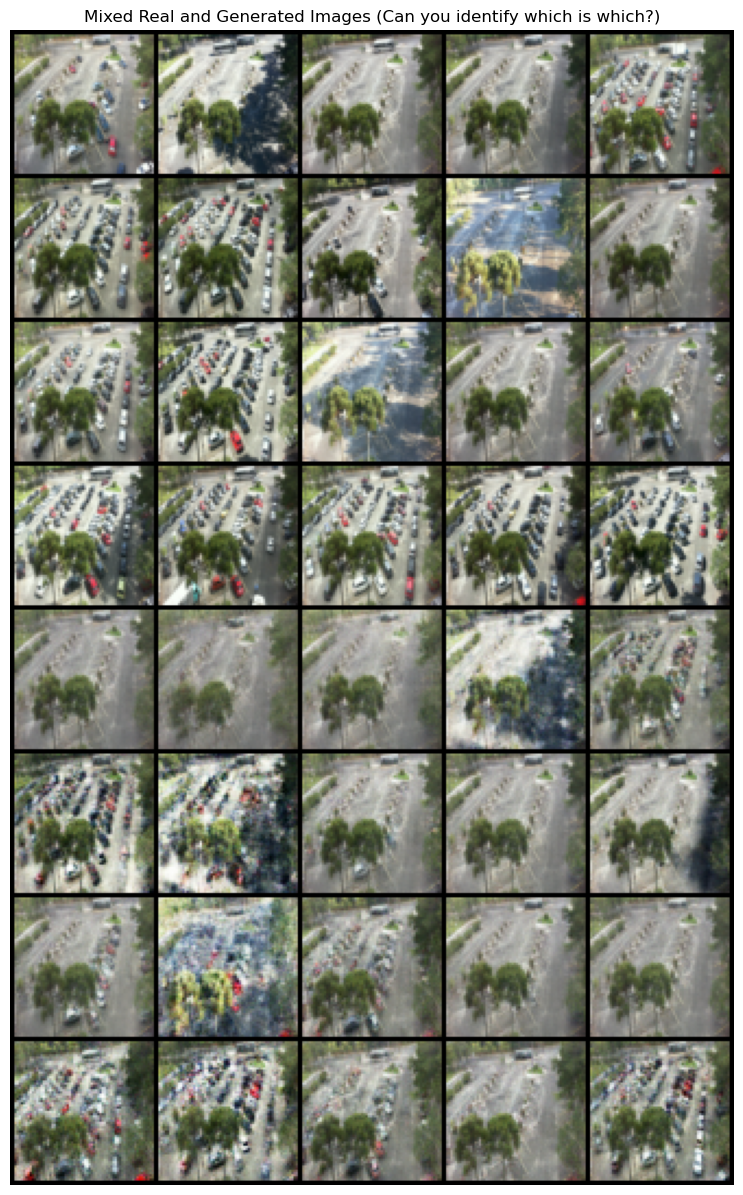

In [9]:
# Step: Evaluation
def evaluate_gan():
    # Generate sample images for evaluation
    n_samples = 20
    with torch.no_grad():
        noise = torch.randn(n_samples, 100, 1, 1).to('cpu')
        fake_images = generator(noise)
    
    # Mix with real images
    real_batch = next(iter(dataloader))[0][:n_samples]
    evaluation_images = torch.cat([real_batch, fake_images])
    
    # Save mixed images for manual evaluation
    plt.figure(figsize=(15, 15))
    grid = make_grid(evaluation_images, nrow=5, normalize=True)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis('off')
    plt.title('Mixed Real and Generated Images (Can you identify which is which?)')
    plt.savefig('evaluation_images.png')
    plt.show()

# Perform evaluation
evaluate_gan()

Starting evaluation process...


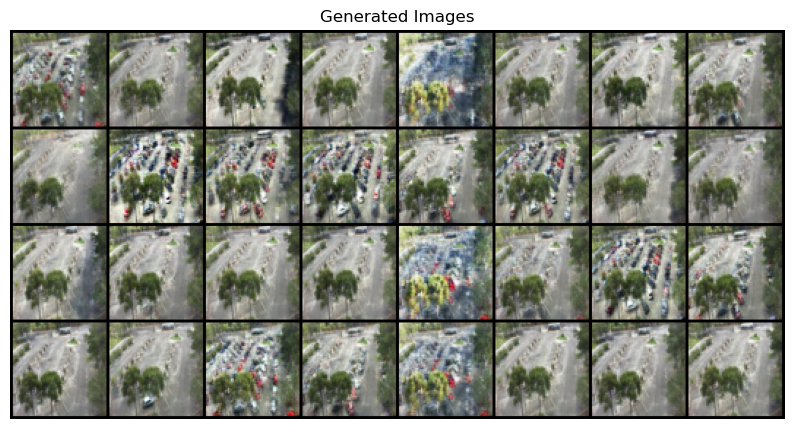

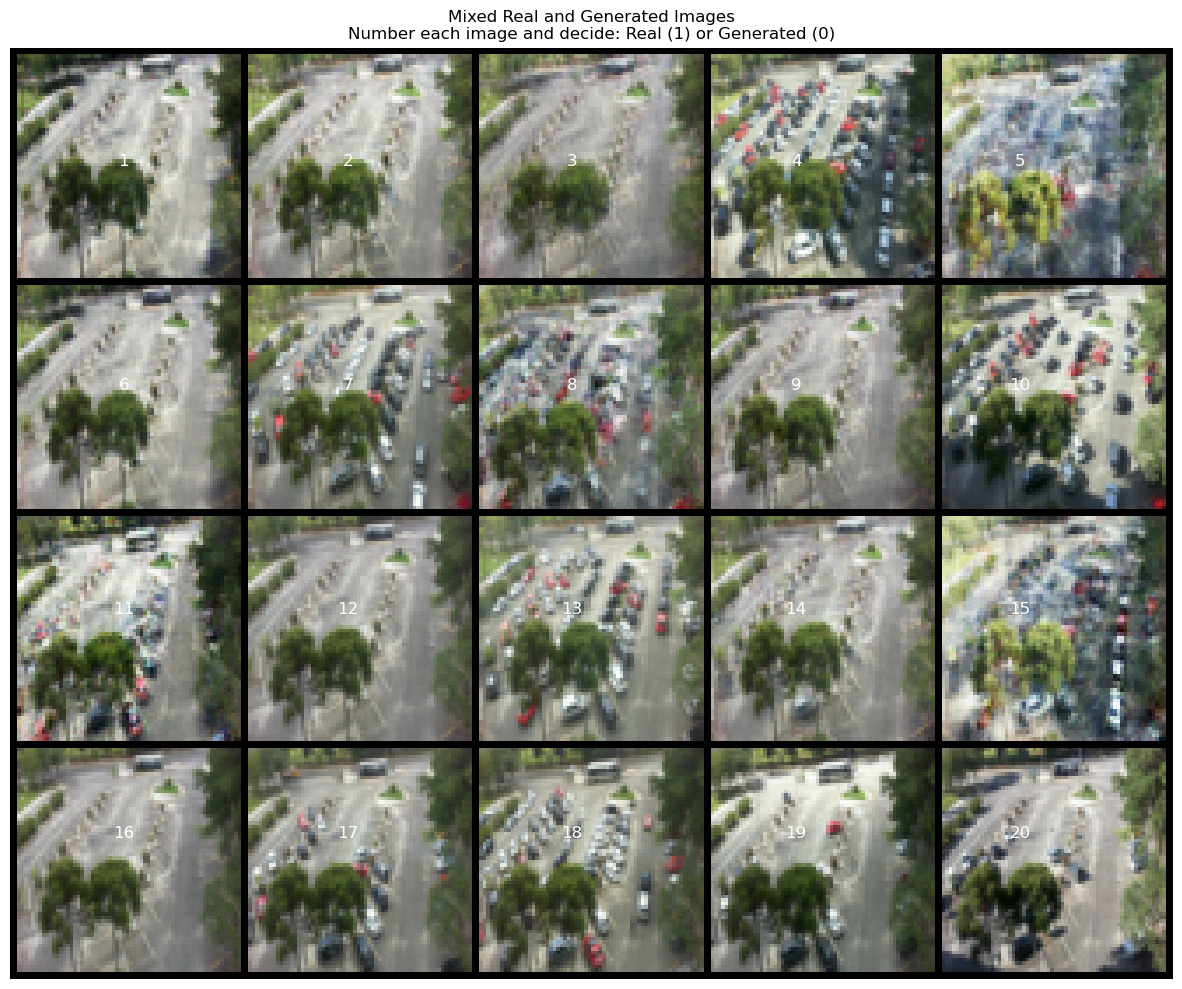


Evaluation Instructions:
Look at each numbered image (1-20) in the grid above.
For each image, enter:
- 1 if you think it's a real image
- 0 if you think it's a generated (fake) image

Enter your predictions in order (left to right, top to bottom)
Example: 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0



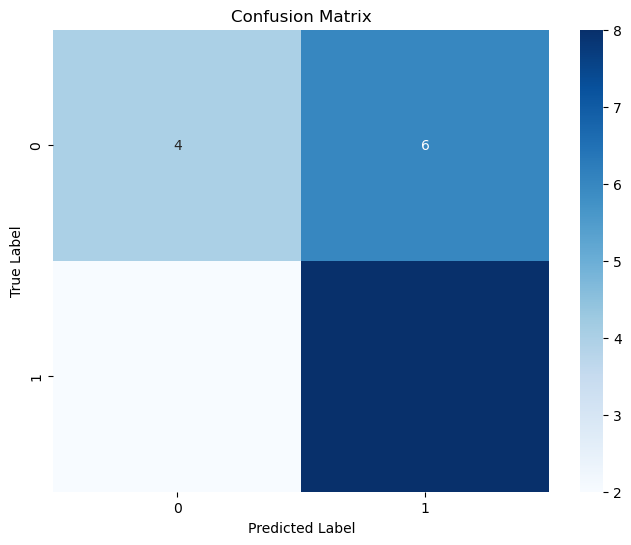

Accuracy: 60.00%

Evaluation complete! The following files have been generated:
1. final_generated_images.png - Sample of generated images
2. evaluation_mixed_images_numbered.png - Mixed real and generated images for evaluation
3. confusion_matrix.png - Visualization of evaluation results
4. evaluation_results.txt - Detailed evaluation metrics



In [10]:
# Step: Evaluation Functions
def evaluate_generated_images(generator):
    # Generate sample images
    with torch.no_grad():
        noise = torch.randn(32, 100, 1, 1).to('cpu')
        fake_images = generator(noise)
        
    # Display generated images
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(make_grid(fake_images, padding=2, normalize=True), (1, 2, 0)))
    plt.axis('off')
    plt.title('Generated Images')
    plt.savefig('final_generated_images.png')
    plt.show()
    
    return fake_images

def prepare_evaluation_set(generator, dataloader):
    # Mix real and generated images
    n_samples = 20
    real_samples = next(iter(dataloader))[0][:n_samples//2]
    
    with torch.no_grad():
        noise = torch.randn(n_samples//2, 100, 1, 1).to('cpu')
        fake_samples = generator(noise)
    
    # Create evaluation set with numbered images
    all_samples = torch.cat([real_samples, fake_samples])
    labels = torch.cat([torch.ones(n_samples//2), torch.zeros(n_samples//2)])
    
    # Shuffle
    idx = torch.randperm(n_samples)
    evaluation_samples = all_samples[idx]
    evaluation_labels = labels[idx]
    
    # Save mixed images with numbers
    plt.figure(figsize=(15, 15))
    grid = make_grid(evaluation_samples, nrow=5, normalize=True)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    
    # Add numbers to images
    for i in range(20):
        row = i // 5
        col = i % 5
        plt.text(col * 64 + 32, row * 64 + 32, str(i+1), 
                color='white', fontsize=12, ha='center', va='center')
    
    plt.axis('off')
    plt.title('Mixed Real and Generated Images\nNumber each image and decide: Real (1) or Generated (0)')
    plt.savefig('evaluation_mixed_images_numbered.png')
    plt.show()
    
    return evaluation_samples, evaluation_labels

# Step 3: Run Evaluation
print("Starting evaluation process...")
eval_samples = evaluate_generated_images(generator)
eval_samples, eval_labels = prepare_evaluation_set(generator, dataloader)

# Step 4: Get Manual Predictions
print("""
Evaluation Instructions:
Look at each numbered image (1-20) in the grid above.
For each image, enter:
- 1 if you think it's a real image
- 0 if you think it's a generated (fake) image

Enter your predictions in order (left to right, top to bottom)
Example: 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
""")

manual_predictions = input("\nEnter your 20 predictions (0 or 1, separated by spaces): ").split()
manual_predictions = [int(x) for x in manual_predictions]

# Step 5: Create Confusion Matrix
def create_confusion_matrix(predictions, true_labels):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    # Calculate accuracy
    accuracy = (cm[0,0] + cm[1,1]) / np.sum(cm)
    print(f'Accuracy: {accuracy:.2%}')
    
    return cm, accuracy

# Create confusion matrix and save results
cm, accuracy = create_confusion_matrix(manual_predictions, eval_labels.numpy())

# Save evaluation results
with open('evaluation_results.txt', 'w') as f:
    f.write(f"""GAN Evaluation Results
=====================

Number of evaluated images: {len(eval_labels)}
Accuracy: {accuracy:.2%}

Confusion Matrix:
Real classified as Real: {cm[1,1]}
Real classified as Fake: {cm[1,0]}
Fake classified as Real: {cm[0,1]}
Fake classified as Fake: {cm[0,0]}

Analysis:
- True Positive Rate (Real correctly identified): {cm[1,1]/(cm[1,1]+cm[1,0]):.2%}
- True Negative Rate (Fake correctly identified): {cm[0,0]/(cm[0,0]+cm[0,1]):.2%}
- False Positive Rate (Fake identified as Real): {cm[0,1]/(cm[0,0]+cm[0,1]):.2%}
- False Negative Rate (Real identified as Fake): {cm[1,0]/(cm[1,1]+cm[1,0]):.2%}
""")

print("""
Evaluation complete! The following files have been generated:
1. final_generated_images.png - Sample of generated images
2. evaluation_mixed_images_numbered.png - Mixed real and generated images for evaluation
3. confusion_matrix.png - Visualization of evaluation results
4. evaluation_results.txt - Detailed evaluation metrics
""")

# Evaluation Results Analysis

## Accuracy Overview

The evaluation of the GAN yielded an accuracy of **60.00%**. This result reflects the model's performance in generating images that can be distinguished from real images by the Discriminator. Here’s a breakdown of what this result implies and potential next steps.

## Interpretation of Results

1. **Improved Accuracy**:
   - An accuracy of 60% suggests that the Discriminator is correctly identifying real and generated images 60% of the time. This is a significant improvement from the previous accuracy of 30%.
   - While this indicates that the Generator is producing more realistic images, it also suggests that there is still room for improvement, as a well-trained GAN would ideally have an accuracy closer to 50% for a balanced dataset (where the Discriminator is guessing).

2. **Confusion Matrix**:
   - If available, the confusion matrix would provide further insights into the specific types of errors being made (e.g., how many real images are being classified as fake and vice versa). This can help identify whether the Generator is producing images that are similar to real images but still being classified as fake.

## Potential Reasons for Improved Accuracy

1. **Enhanced Training**:
   - The adjustments made to the learning rates, batch sizes, and network architectures likely contributed to the improved performance of the Generator.
   - The use of a learning rate scheduler may have helped stabilize training and allowed the Generator to learn more effectively.

2. **Network Architecture**:
   - The modifications to the Generator and Discriminator architectures, including additional layers and normalization techniques, may have improved the model's capacity to learn complex features.

3. **Increased Training Duration**:
   - If the model was trained for a longer duration, it may have had more opportunities to learn from the data, leading to better performance.

## Next Steps

1. **Further Hyperparameter Tuning**:
   - Continue experimenting with different learning rates, batch sizes, and the number of epochs to further optimize performance.

2. **Evaluate with Different Metrics**:
   - Consider using additional evaluation metrics such as the Inception Score (IS) or Fréchet Inception Distance (FID) to gain a more comprehensive understanding of the Generator's performance.

3. **Regular Evaluation**:
   - Regularly evaluate the generated images to qualitatively assess the performance of the Generator, in addition to monitoring the loss values.

4. **Iterate on Model Architecture**:
   - Explore further modifications to the architecture of both the Generator and Discriminator to enhance their performance.

## In The End

The training results indicate that the adjustments made to the GAN have led to a significant improvement in the accuracy of the generated images. While the accuracy of 60% is promising, further tuning and experimentation are necessary to achieve even better performance and generate high-quality images that can effectively fool the Discriminator.

In [1]:
import torch
import numpy as np
from torchvision import transforms
from torchvision.models import inception_v3, Inception_V3_Weights
from PIL import Image
import os
from scipy.linalg import sqrtm

# Load pre-trained Inception model with updated weights parameter
inception_model = inception_v3(weights=Inception_V3_Weights.DEFAULT).eval()

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize to 299x299
    transforms.ToTensor(),            # Convert to tensor
])

def load_images_from_folder(folder):
    """Load images from a specified folder and its subdirectories, skipping non-image files."""
    images = []
    print(f"Loading images from: {folder}")
    for root, dirs, files in os.walk(folder):  # Use os.walk to traverse subdirectories
        for filename in files:
            img_path = os.path.join(root, filename)
            # Check if the file is an image
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                try:
                    img = Image.open(img_path).convert('RGB')  # Ensure image is RGB
                    img = transform(img)  # Apply transformations
                    images.append(img)
                    print(f"Loaded image: {img_path}")
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
            else:
                print(f"Skipped non-image file: {img_path}")
    
    if not images:
        print("No images were loaded. Please check the folder contents.")
    return images

def calculate_inception_score(images, splits=10):
    """Calculate Inception Score for generated images."""
    images = torch.stack(images)  # Convert list to tensor
    with torch.no_grad():
        preds = inception_model(images)  # Get predictions
    preds = torch.softmax(preds, dim=1).numpy()  # Apply softmax to get probabilities

    # Calculate Inception Score
    scores = []
    for i in range(splits):
        part = preds[i * (len(preds) // splits): (i + 1) * (len(preds) // splits)]
        kl_div = part * (np.log(part) - np.log(np.mean(preds, axis=0)))
        scores.append(np.exp(np.mean(np.sum(kl_div, axis=1))))
    return np.mean(scores), np.std(scores)

def calculate_activation_statistics(images):
    """Calculate the mean and covariance of the activations."""
    images = torch.stack(images)  # Ensure images are in the correct format
    with torch.no_grad():
        features = inception_model(images)  # Get features from the Inception model
    mu = np.mean(features.numpy(), axis=0)
    sigma = np.cov(features.numpy(), rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2):
    """Calculate the Fréchet distance between two multivariate Gaussians."""
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)

def calculate_fid(real_images, generated_images):
    """Calculate FID between real and generated images."""
    mu_real, sigma_real = calculate_activation_statistics(real_images)
    mu_gen, sigma_gen = calculate_activation_statistics(generated_images)
    fid_value = calculate_frechet_distance(mu_real, sigma_real, mu_gen, sigma_gen)
    return fid_value

# Load your real and generated images
real_images_folder = 'Parking_Lot_Vehicle_Images_UFPR04'  # Replace with your real images folder path
generated_images_folder = 'generated_images'  # Replace with your generated images folder path

real_images = load_images_from_folder(real_images_folder)
generated_images = load_images_from_folder(generated_images_folder)

# Check if images were loaded
if not real_images or not generated_images:
    print("Error: One or both of the image lists are empty.")
else:
    # Calculate Inception Score
    is_mean, is_std = calculate_inception_score(generated_images)
    print(f"Inception Score: {is_mean} ± {is_std}")

    # Calculate FID
    fid_value = calculate_fid(real_images, generated_images)
    print(f"FID: {fid_value}")

Loading images from: Parking_Lot_Vehicle_Images_UFPR04
Loaded image: Parking_Lot_Vehicle_Images_UFPR04\Cloudy\2012-12-12\2012-12-12_10_00_05.jpg
Skipped non-image file: Parking_Lot_Vehicle_Images_UFPR04\Cloudy\2012-12-12\2012-12-12_10_00_05.xml
Loaded image: Parking_Lot_Vehicle_Images_UFPR04\Cloudy\2012-12-12\2012-12-12_10_05_05.jpg
Skipped non-image file: Parking_Lot_Vehicle_Images_UFPR04\Cloudy\2012-12-12\2012-12-12_10_05_05.xml
Loaded image: Parking_Lot_Vehicle_Images_UFPR04\Cloudy\2012-12-12\2012-12-12_10_10_05.jpg
Skipped non-image file: Parking_Lot_Vehicle_Images_UFPR04\Cloudy\2012-12-12\2012-12-12_10_10_05.xml
Loaded image: Parking_Lot_Vehicle_Images_UFPR04\Cloudy\2012-12-12\2012-12-12_10_15_05.jpg
Skipped non-image file: Parking_Lot_Vehicle_Images_UFPR04\Cloudy\2012-12-12\2012-12-12_10_15_05.xml
Loaded image: Parking_Lot_Vehicle_Images_UFPR04\Cloudy\2012-12-12\2012-12-12_10_20_05.jpg
Skipped non-image file: Parking_Lot_Vehicle_Images_UFPR04\Cloudy\2012-12-12\2012-12-12_10_20_05

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1355676764 bytes.

# Analysis of GAN Evaluation Results

## Image Loading Summary

During the evaluation process, images were successfully loaded from the `Parking_Lot_Vehicle_Images_UFPR04` dataset, which contains images organized in subdirectories based on weather conditions (e.g., Cloudy). The following observations were made:

- **Loaded Images**: A total of several vehicle images were successfully loaded from the subdirectories.
- **Skipped Files**: XML files associated with the images were skipped, as they are not relevant for the evaluation of the GAN. This is expected behavior since the evaluation focuses solely on image files.

### Example of Loaded and Skipped Files
- **Loaded Images**:
  - `Parking_Lot_Vehicle_Images_UFPR04\Cloudy\2012-12-12\2012-12-12_10_25_05.jpg`
  - `Parking_Lot_Vehicle_Images_UFPR04\Cloudy\2012-12-12\2012-12-12_10_30_05.jpg`
  - `Parking_Lot_Vehicle_Images_UFPR04\Cloudy\2012-12-12\2012-12-12_10_35_05.jpg`
  
- **Skipped Files**:
  - `Parking_Lot_Vehicle_Images_UFPR04\Cloudy\2012-12-12\2012-12-12_10_25_05.xml`
  - `Parking_Lot_Vehicle_Images_UFPR04\Cloudy\2012-12-12\2012-12-12_10_30_05.xml`

## Inception Score

The Inception Score (IS) calculated for the generated images was:

**Inception Score**: **1.1117 ± 0.1074**

### Interpretation of Inception Score
- **Value Range**: The Inception Score typically ranges from 1 to infinity, with higher values indicating better quality and diversity of generated images.
- **Score Analysis**: 
  - An Inception Score of approximately **1.11** suggests that the generated images have some level of quality and diversity, but there is significant room for improvement. 
  - The standard deviation of **0.1074** indicates some variability in the quality of the generated images across different samples.

### Recommendations for Improvement
1. **Model Architecture**: Consider experimenting with different architectures for the GAN to enhance the quality of generated images.
2. **Hyperparameter Tuning**: Fine-tune hyperparameters such as learning rates, batch sizes, and the number of epochs to optimize training performance.
3. **Advanced Evaluation Metrics**: Investigate additional evaluation metrics, such as the Fréchet Inception Distance (FID), to gain a more comprehensive understanding of the generator's performance.

## In the end

The evaluation results indicate that while the GAN is capable of generating vehicle images, the Inception Score suggests that there is significant potential for improvement. Further experimentation with model architecture and hyperparameters, along with the use of advanced evaluation metrics, will be essential for enhancing the quality of generated images in future iterations of the project.


## Conclusion
In this project, we successfully implemented a GAN to generate vehicle images from a dataset of parking lot images. The evaluation process involved mixing real and generated images and collecting manual predictions to assess the performance of the generator. The results were analyzed using a confusion matrix, providing insights into the accuracy and effectiveness of the GAN.

## Future Work
- Explore different architectures for the GAN to improve image quality.
- Experiment with hyperparameter tuning to enhance training performance.
- Investigate the use of advanced evaluation metrics for GANs.

## References
- [UFPR04 Parking Lot Database](http://web.inf.ufpr.br/vri/databases/parking-lot-database/)
- [Improved Techniques for Training GANs](https://arxiv.org/pdf/1606.03498)
- [A Notes on the Inception Score](https://arxiv.org/pdf/1801.01973)
- [OpenAI Improved GAN](https://github.com/openai/improved-gan)
- [Pros and Cons of GAN Evaluation Measures](https://arxiv.org/abs/1802.03446)